In [9]:
# Import 
import os
import time
import json
import datetime
import pandas as pd
import numpy as np

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5
from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.utils import ar_calculation
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
SIM_DIR = Path('/home/admin-suz/Documents/Simulations/')
today = datetime.date.today()

sim_save_dir = SIM_DIR/f'{today.isoformat()}_TissuPolarization'

try:
    os.mkdir(sim_save_dir)
except FileExistsError:
    pass

In [11]:
from polarity.toolbox import define_polarity
from polarity.dynamics import EllipsoidLameGeometry as geom

In [12]:
from polarity.dynamics import RadialTension, BarrierElasticity, PerimeterElasticity

smodel = model_factory(
    [
        BarrierElasticity,
        RadialTension,
        PerimeterElasticity,
        effectors.FaceAreaElasticity,
        effectors.LumenVolumeElasticity,
    ], effectors.FaceAreaElasticity)


model = smodel

In [13]:
def init():
    dsets = hdf5.load_datasets('../examples/superegg_final.hf5',
                               data_names=['vert', 'edge', 'face'])

    with open('../examples/superegg_final.json', 'r+') as fp:
        specs = json.load(fp)

    sheet = Sheet('spherical', dsets, specs)    
    
    sheet.settings['geometry'] = "spherical"
    sheet.settings['lumen_vol_elasticity'] = 1.e-5
    sheet.settings['barrier_ray'] = 100

    sheet.vert_df['barrier_elasticity'] = 280.0
    sheet.vert_df['delta_rho'] = 0
    
    # A définir en fonction de l'angle de la jonction
    sheet.edge_df['weighted'] = 1.
    sheet.edge_df['weighted_length'] = sheet.edge_df.weighted * sheet.edge_df.length
    
    sheet.face_df['radial_tension'] = 0.0
    sheet.face_df['prefered_perimeter'] = 2*np.sqrt(sheet.face_df['prefered_area'])
    sheet.face_df['perimeter_elasticity'] = 5.
    sheet.face_df['area_elasticity'] = 1.
    
    return sheet
sheet=init()

In [14]:
solver = QSSolver(with_t1=False, with_t3=False)

## Test several value of polarity ratio

In [19]:
#[1, 0.9]
perpendicular_weighted = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

first = 0
for pw in perpendicular_weighted : 
    print (pw)
    sheet=init()
    define_polarity(sheet, 1, pw)

    res = solver.find_energy_min(sheet, geom, model, options={"gtol": 1e-8})
    
    name_file = os.path.join(sim_save_dir, '{:1.1f}.hf5'.format(pw))
    hdf5.save_datasets(name_file, sheet)
    
    sheet_ = sheet.extract_bounding_box(z_boundary=(-80,80), x_boundary=(20,100))
    anisotropy = ar_calculation(sheet_, ['y','z'])
    
    if first :
        data_polarity = pd.DataFrame({ pw:anisotropy} )
        first = 0
    else : 
        data_polarity[pw]=anisotropy



0.8
0.7
0.6
0.5
0.4
0.3
0.2
0.1


In [45]:
data_polarity.to_csv('data_polarity.csv')

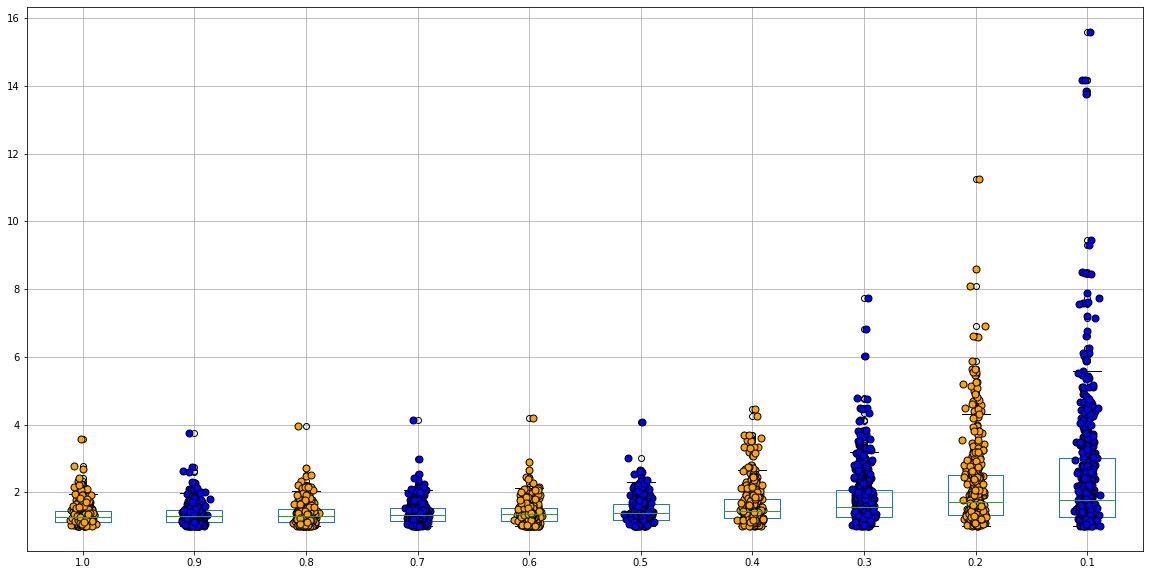

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = data_polarity

fig = plt.figure(1,figsize=(20, 10))
#create automatically box plot from data_frame
data.boxplot()

for i,d in enumerate(data):
    y = data[d]
    x = np.random.normal(i+1, 0.04, len(y))
    plt.plot(x, y, mfc = ["orange","blue","orange","blue","orange","blue","orange","blue","orange","blue"][i], mec='k', ms=7, marker="o", linestyle="None")



#plt.show()
plt.savefig('TissuePolarization.svg', dpi = 300, transparent=True)
plt.savefig("TissuePolarization.pdf", dpi = 300, transparent=True)

In [30]:
import scipy
from scipy.stats import ttest_rel

print('0.9',ttest_rel(data_polarity[1.0], data_polarity[0.9], nan_policy='omit'))
print('0.8',ttest_rel(data_polarity[1.0], data_polarity[0.8], nan_policy='omit'))
print('0.7',ttest_rel(data_polarity[1.0], data_polarity[0.7], nan_policy='omit'))
print('0.6',ttest_rel(data_polarity[1.0], data_polarity[0.6], nan_policy='omit'))
print('0.5',ttest_rel(data_polarity[1.0], data_polarity[0.5], nan_policy='omit'))
print('0.4',ttest_rel(data_polarity[1.0], data_polarity[0.4], nan_policy='omit'))
print('0.3',ttest_rel(data_polarity[1.0], data_polarity[0.3], nan_policy='omit'))
print('0.2',ttest_rel(data_polarity[1.0], data_polarity[0.2], nan_policy='omit'))
print('0.1',ttest_rel(data_polarity[1.0], data_polarity[0.1], nan_policy='omit'))

0.9 Ttest_relResult(statistic=-0.7162213692407945, pvalue=0.474205894595199)
0.8 Ttest_relResult(statistic=-1.3017767047095226, pvalue=0.19363175144372566)
0.7 Ttest_relResult(statistic=-1.955610946437113, pvalue=0.051117297580808185)
0.6 Ttest_relResult(statistic=-2.7124851518458777, pvalue=0.006933448299786896)
0.5 Ttest_relResult(statistic=-5.058691692026387, pvalue=6.174547067418973e-07)
0.4 Ttest_relResult(statistic=-8.948320136249693, pvalue=9.751815379514613e-18)
0.3 Ttest_relResult(statistic=-11.45102866481494, pvalue=8.722636792745623e-27)
0.2 Ttest_relResult(statistic=-13.299849406026183, pvalue=3.1371777526544395e-34)
0.1 Ttest_relResult(statistic=-12.16716057319287, pvalue=1.126369928361572e-29)


0.5.hf5
0.2.hf5
0.1.hf5
0.6.hf5
0.9.hf5
0.8.hf5
0.7.hf5
0.3.hf5
0.4.hf5
1.0.hf5


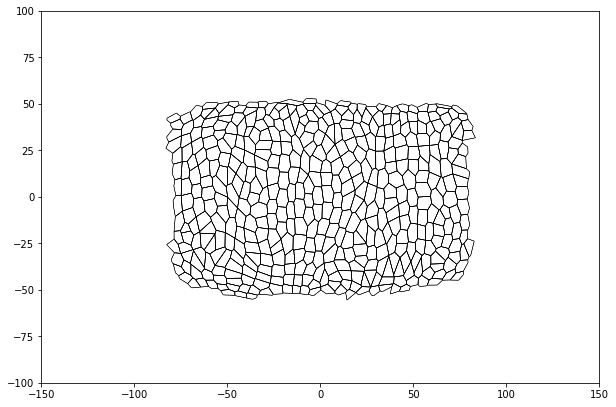

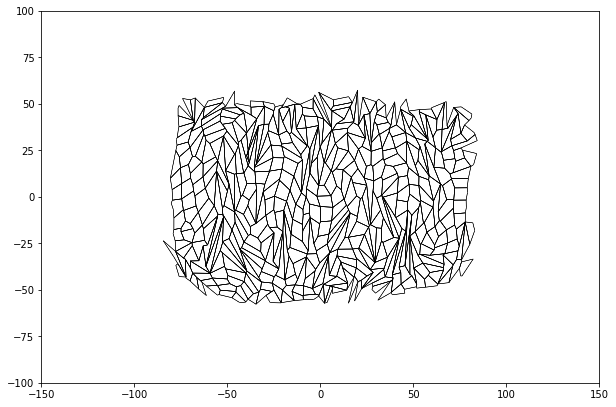

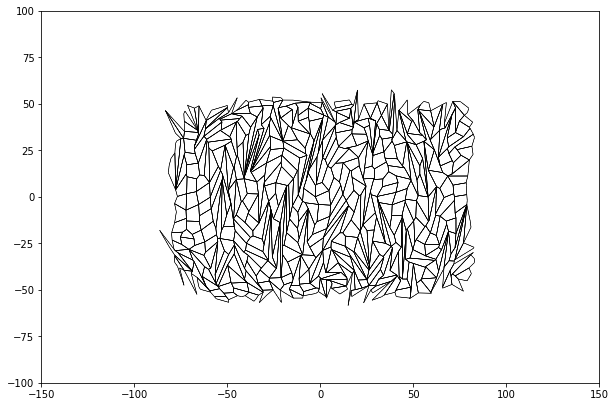

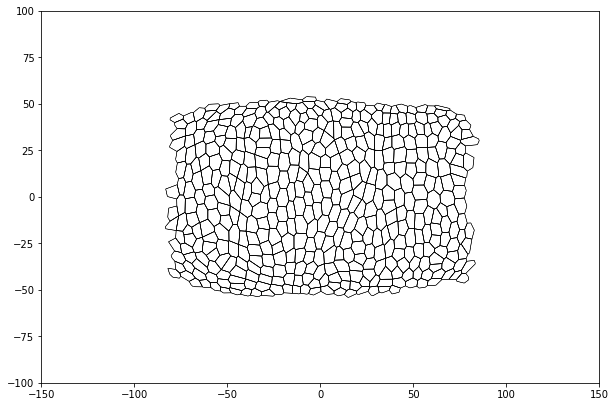

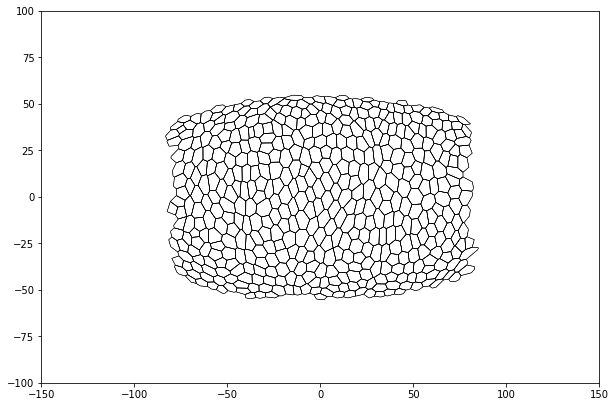

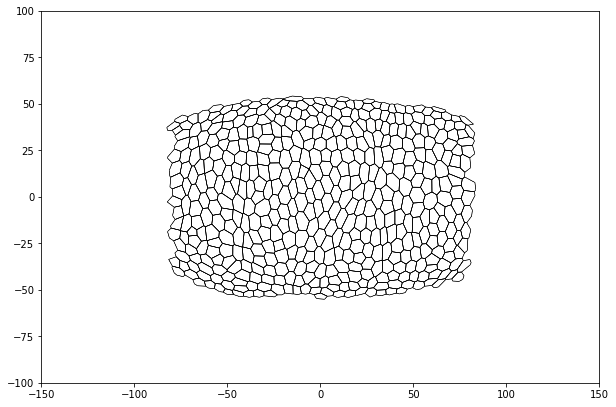

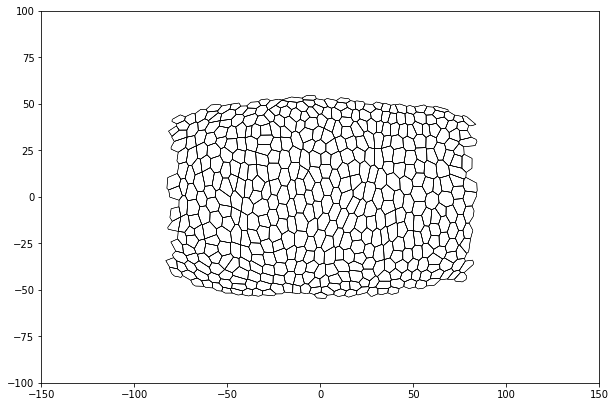

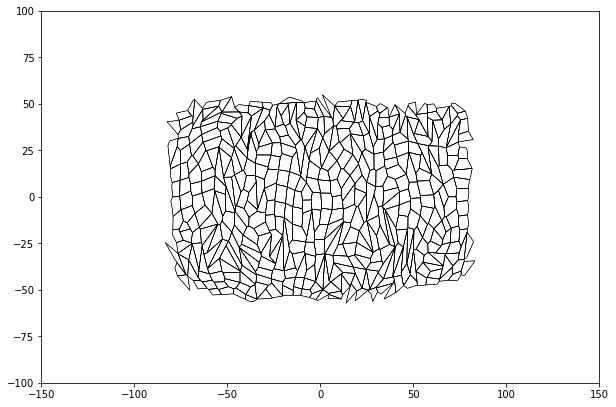

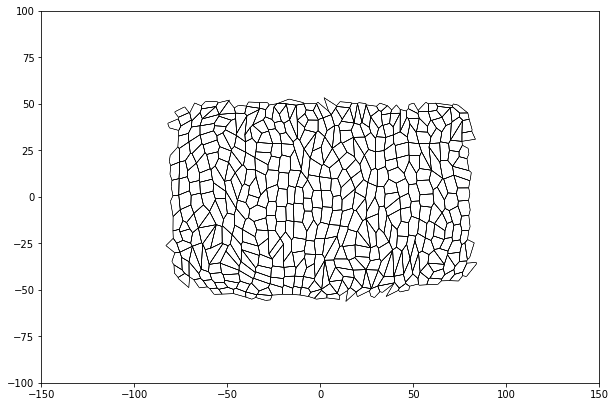

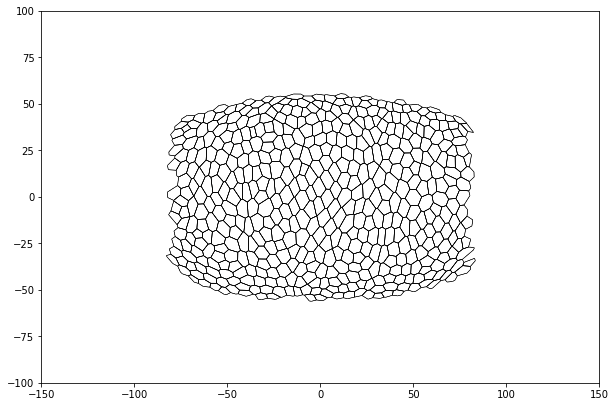

In [42]:
def open_sheet(file_name, data_names=['vert', 'edge', 'face', 'cell']):
    """Open hdf5 file

    Open HDF5 file correspond to t time from dirname directory.

    Parameters
    ----------
    directory : str
        complete directory path
    t : int
        time step
    """
    dsets = hdf5.load_datasets(file_name,
                               data_names=data_names)

    
    sheet = Sheet('ellipse', dsets)
    return sheet

def draw_specs(sheet):
    specs = {
        'edge': {
            'visible': True,
            'color':'k'
            #'color': sheet.edge_df['stress'],
            #"colormap":'bwr',
            #'color_range':(-20,20)
        },
        'face': {
            'visible': False,
            'color':'white',
            #'colormap': 'Blues',
            'alpha':0.5

        },
        'vert':{
            'visible':False,
            's':100,
            'alpha': 0.3,
            'zorder': 2,


        }

    }
    return specs

from tyssue.draw import sheet_view
from os import listdir
list_file = listdir(sim_save_dir)
for f in list_file : 
    print(f)
    sheet = open_sheet(os.path.join(sim_save_dir,f))
    sheet_=sheet.extract_bounding_box(x_boundary=(20,100), z_boundary=(-80,80))
    fig, ax = sheet_view(sheet_, ['z', 'y'], mode="2D", **draw_specs(sheet_))
    ax.set_ylim(-100,100)
    ax.set_xlim(-150,150)

    fig.set_size_inches(10,10)
    plt.savefig(f+'.png', dpi = 300, transparent=True)
    

In [1]:
import plotly.express as px
tips = px.data.tips()
fig = px.box(tips, x="time", y="total_bill", points="all")
fig.show()